# Análise exploratória de instrumentos de medição

In [29]:
!pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable


In [30]:
from pyspark.sql import SparkSession

spark = (
    SparkSession.builder
    .master("local")
    .appName("Análise de instrumentos")
    .config('spark.ui.port', '4050')
    .getOrCreate()
)

In [31]:
path = './tabela_instrumentos.csv'
instrumentos = spark.read.csv(path, inferSchema=True, header=True)
instrumentos = instrumentos.na.fill(value="", subset=["Data_Entrega"])
instrumentos.toPandas()

,N°_da_Amostra,Instrumentos_do_lote,Quantidade_instrumentos,Status_atual,Data_prazo,Data_Entrega
0,1,Rugosímetro,5,Atrasado,14/11/2023,16/11/2023
1,32,Luxímetro digital,55,Entregue,14/11/2023,14/11/2023
2,3,Paquímetro,29,Atrasado,14/11/2023,18/11/2023
3,4,Decibelímetro,18,Entregue antes,14/11/2023,13/11/2023
4,5,Micrômetro,43,Entregue,14/11/2023,14/11/2023
5,6,Trena,11,Atrasado,14/11/2023,17/11/2023
6,7,Relógio comparador,24,Atrasado,14/11/2023,17/11/2023
7,8,Dosímetro Digital,8,Entregue,14/11/2023,14/11/2023
8,9,Detector de gás,21,Atrasado,14/11/2023,20/11/2023
9,10,Medidor de camadas,15,Não entregue,14/11/2023,


In [32]:

instrumentos.describe()

DataFrame[summary: string, N°_da_Amostra: string, Instrumentos_do_lote: string, Quantidade_instrumentos: string, Status_atual: string, Data_prazo: string, Data_Entrega: string]

In [33]:
instrumentos.printSchema()

root
 |-- N°_da_Amostra: integer (nullable = true)
 |-- Instrumentos_do_lote: string (nullable = true)
 |-- Quantidade_instrumentos: integer (nullable = true)
 |-- Status_atual: string (nullable = true)
 |-- Data_prazo: string (nullable = true)
 |-- Data_Entrega: string (nullable = false)



In [34]:
instrumentos.summary().show()

+-------+-----------------+--------------------+-----------------------+------------+----------+------------+
|summary|    N°_da_Amostra|Instrumentos_do_lote|Quantidade_instrumentos|Status_atual|Data_prazo|Data_Entrega|
+-------+-----------------+--------------------+-----------------------+------------+----------+------------+
|  count|               10|                  10|                     10|          10|        10|          10|
|   mean|              8.5|                NULL|                   22.9|        NULL|      NULL|        NULL|
| stddev|8.708233651742088|                NULL|     15.800492256748065|        NULL|      NULL|        NULL|
|    min|                1|       Decibelímetro|                      5|    Atrasado|14/11/2023|            |
|    25%|                4|                NULL|                     11|        NULL|      NULL|        NULL|
|    50%|                6|                NULL|                     18|        NULL|      NULL|        NULL|
|    75%| 

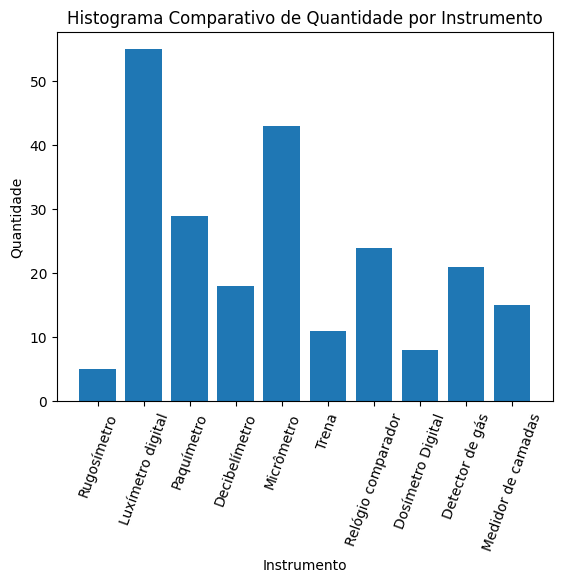

In [38]:
from matplotlib import pyplot as plt

plt.bar(instrumentos.toPandas()["Instrumentos_do_lote"], instrumentos.toPandas()["Quantidade_instrumentos"])
plt.title('Histograma Comparativo de Quantidade por Instrumento')
plt.xlabel('Instrumento')
plt.ylabel('Quantidade')
# Rotacione as labels do eixo x
plt.xticks(rotation=70)
plt.show()

# Construção do KPI a partir da porcentagem de instrumentos entregues no prazo

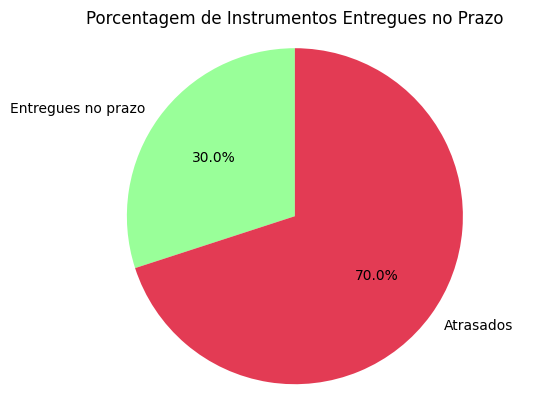

In [36]:
total_instrumentos = instrumentos.count()
entregues_no_prazo = instrumentos.filter("Status_atual = 'Entregue' AND Data_Entrega = Data_prazo").count()
porcentagem_entregues_no_prazo = (entregues_no_prazo / total_instrumentos) * 100

# Crie um gráfico de pizza para visualizar o KPI
labels = ['Entregues no prazo', 'Atrasados']
sizes = [porcentagem_entregues_no_prazo, 100 - porcentagem_entregues_no_prazo]
colors = ['#99ff99','#e33b54']

plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90)
plt.title('Porcentagem de Instrumentos Entregues no Prazo')
plt.axis('equal')  # Equal aspect ratio garante que o gráfico de pizza seja circular.
plt.show()

# KPI de Produtividade - Total de produtos entregues por dia

In [48]:
from pyspark.sql.functions import col, to_date
from pyspark.sql import functions as F

# Convertemos a coluna de data para o formato Date
instrumentos = instrumentos.withColumn("Data_prazo", to_date(col("Data_prazo"), "dd/MM/yyyy"))
instrumentos = instrumentos.withColumn("Data_Entrega", to_date(col("Data_Entrega"), "dd/MM/yyyy"))

# Calcula a quantidade total de instrumentos entregues
total_entregues = instrumentos.filter("Status_atual = 'Entregue'").agg(F.sum("Quantidade_instrumentos")).collect()[0][0]

total_ideal = 0.7 * sum(instrumentos.toPandas()["Quantidade_instrumentos"]) # 70% dos instrumentos entregues no prazo

# Calcula o número total de dias
data_inicial = instrumentos.select(F.min("Data_prazo")).collect()[0][0]
data_final = instrumentos.select(F.max("Data_Entrega")).collect()[0][0]
total_dias = (data_final - data_inicial).days + 1  # Adiciona 1 para incluir o dia final



# Calcula a produtividade real, produtividade ideal
produtividade_real = total_entregues / total_dias
produtividade_ideal = total_ideal/total_dias

kpi_prod = (total_entregues/sum(instrumentos.toPandas()['Quantidade_instrumentos']) * 100)

print(f"Total de Instrumentos Entregues: {total_entregues}")
print(f"Total de Dias: {total_dias}")
print(f"Produtividade Ideal: {produtividade_ideal:.2f} instrumentos/dia  -  Produtividade Real: {produtividade_real:.2f} instrumentos/dia")
print(f"KPI atual de produtividade por dia {kpi_prod:.2f}%")



Total de Instrumentos Entregues: 106
Total de Dias: 7
Produtividade Ideal: 22.90 instrumentos/dia  -  Produtividade Real: 15.14 instrumentos/dia
KPI atual de produtividade por dia 46.29%
